# Eliran Refaeli & Guy Dinar

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive, files

#functions
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# measures
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, f1_score, precision_score

# Dataset

In [2]:
dataset = 'https://raw.githubusercontent.com/GuyDinar/PublicRep/main/Final%20Project%20Dataset/Healthcare%20Stroke%20Dataset.csv'
df = pd.read_csv(dataset)

In [3]:
before_rows = df.shape[0]
before_columns = df.shape[1]
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


# Basic Info + Describe

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

# Column Description

* **id:** unique identifier (will be removed)
* **gender**: "Male", "Female" or "Other" ("Other" be removed)
* **age**: age of the patient
* **hypertension**: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
* **heart_disease**: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
* **ever_married**: "No" or "Yes" (will be changed to 0 and 1)
* **work_type**: "children", "Govt_job", "Never_worked", "Private" or "Self-employed" (will be changed to dummies)
* **Residence_type**: "Rural" or "Urban" (will be changed to 0 and 1)
* **avg_glucose_level**: average glucose level in blood (will check measurement unit)
* **bmi**: body mass index
* **smoking_status**: "formerly smoked", "never smoked", "smokes" or "Unknown" (will be changed to dummies) 
* **stroke**: 0 if the patient didn't have a stroke, 1 if they did

In [6]:
df.describe(include='all')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110.000000,5110,5110.000000,5110.000000,5110.000000,5110,5110,5110,5110.000000,4909.000000,5110,5110.000000
unique,NaN,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,NaN,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,NaN,2994,NaN,NaN,NaN,3353,2925,2596,NaN,NaN,1892,NaN
mean,36517.829354,NaN,43.226614,0.097456,0.054012,NaN,NaN,NaN,106.147677,28.893237,NaN,0.048728
std,21161.721625,NaN,22.612647,0.296607,0.226063,NaN,NaN,NaN,45.283560,7.854067,NaN,0.215320
min,67.000000,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,10.300000,NaN,0.000000
25%,17741.250000,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.245000,23.500000,NaN,0.000000
50%,36932.000000,NaN,45.000000,0.000000,0.000000,NaN,NaN,NaN,91.885000,28.100000,NaN,0.000000
75%,54682.000000,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,114.090000,33.100000,NaN,0.000000


Conclusions:
1. Remove the single "Other" gender record
2. Remove low age records (maybe)
3. Very unbalanced data

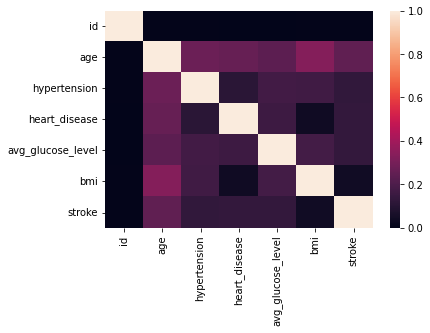

In [7]:
# Seaborn
sns.heatmap(df.corr());

Conclusion: No strong correlation

# Clean the dataframe

In [8]:
df.rename(columns={'Residence_type': 'residence_type'}, inplace=True)

In [9]:
df.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


## Dealing with NULLS - BMI

In [10]:
df[df.bmi.isnull()] # 201 rows

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


In [11]:
df[df.bmi.isnull()]['stroke'].value_counts() # How many strokes for null BMIs

0    161
1     40
Name: stroke, dtype: int64

We decided to fill the nulls with average of GENDER & SMOKING STATUS (and maybe more)

In [12]:
df_bmi_notnull = df[~df.bmi.isnull()]
df_bmi_notnull

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [13]:
# Group by gender, smoking - to get the average to fill in later
gender_smoking_groupby = df_bmi_notnull.groupby(['gender', 'smoking_status'], as_index=False).bmi.mean().round(1)
gender_smoking_groupby

,gender,smoking_status,bmi
0,Female,Unknown,26.1
1,Female,formerly smoked,30.6
2,Female,never smoked,29.9
3,Female,smokes,30.8
4,Male,Unknown,25.1
5,Male,formerly smoked,30.9
6,Male,never smoked,30.2
7,Male,smokes,30.3
8,Other,formerly smoked,22.4


In [14]:
# join the GROUP BY dataset to the original one
df = pd.merge(gender_smoking_groupby, df, on=['gender','smoking_status'], how='left', suffixes=('_old', ''))

In [15]:
# Fill nulls with the new average
df.bmi.fillna(df.bmi_old, inplace=True)
df.drop(columns=['bmi_old'], inplace=True)
df

,gender,smoking_status,id,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,stroke
0,Female,Unknown,27419,59.0,0,0,Yes,Private,Rural,76.15,26.1,1
1,Female,Unknown,60491,78.0,0,0,Yes,Private,Urban,58.57,24.2,1
2,Female,Unknown,37937,75.0,0,1,No,Self-employed,Urban,109.78,26.1,1
3,Female,Unknown,18587,76.0,0,0,No,Private,Urban,89.96,26.1,1
4,Female,Unknown,26015,66.0,0,0,Yes,Self-employed,Urban,101.45,26.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,Male,smokes,28788,40.0,0,0,Yes,Private,Urban,191.15,30.3,0
5106,Male,smokes,29540,67.0,0,0,Yes,Private,Rural,97.04,26.9,0
5107,Male,smokes,4211,26.0,0,0,No,Govt_job,Rural,100.85,21.0,0
5108,Male,smokes,7293,40.0,0,0,Yes,Private,Rural,83.94,30.3,0


In [16]:
df[df.bmi.isnull()] # show no records

,gender,smoking_status,id,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,stroke


## Gender

In [17]:
df.gender.value_counts()
# There is only one record of "Other" gender

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [18]:
idx = df[df.gender == 'Other'].index[0]
df.drop(index=idx, inplace=True)

In [19]:
df[df.gender == 'Other']

,gender,smoking_status,id,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,stroke


## Removing ID column

In [20]:
df.drop(columns=['id'], inplace=True)
df.head(2)

,gender,smoking_status,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,stroke
0,Female,Unknown,59.0,0,0,Yes,Private,Rural,76.15,26.1,1
1,Female,Unknown,78.0,0,0,Yes,Private,Urban,58.57,24.2,1


## Removing outliers

In [21]:
def detect_outliers(df, features):
    ### For each feature, the function calculates IQR, then outliers, then returns rows where there is more than one outlier
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_idx = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_idx)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v == 2)
    
    return multiple_outliers

In [22]:
# shows the outliers
df_outliers = df.loc[detect_outliers(df, ['avg_glucose_level', 'bmi'])]
df_outliers.shape

(34, 11)

In [23]:
df_outliers

,gender,smoking_status,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,stroke
26,Female,Unknown,47.0,0,0,Yes,Private,Urban,210.95,50.1,0
184,Female,Unknown,50.0,0,0,Yes,Private,Rural,217.39,50.6,0
223,Female,Unknown,82.0,0,0,Yes,Private,Urban,253.16,47.5,0
552,Female,Unknown,68.0,0,0,Yes,Govt_job,Urban,228.05,51.9,0
945,Female,formerly smoked,50.0,0,0,Yes,Private,Rural,206.25,53.4,0
1030,Female,formerly smoked,40.0,0,0,Yes,Self-employed,Rural,212.97,49.8,0
1143,Female,formerly smoked,66.0,1,0,Yes,Govt_job,Urban,205.01,52.7,0
1192,Female,formerly smoked,73.0,1,0,No,Self-employed,Rural,198.30,54.3,0
1197,Female,formerly smoked,38.0,0,0,No,Private,Urban,218.60,47.9,0
1320,Female,never smoked,52.0,1,0,Yes,Self-employed,Urban,233.29,48.9,1


In [24]:
df_outliers.stroke.value_counts()

0    31
1     3
Name: stroke, dtype: int64

In [25]:
df.drop(df_outliers.index, inplace=True)
df

,gender,smoking_status,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,stroke
0,Female,Unknown,59.0,0,0,Yes,Private,Rural,76.15,26.1,1
1,Female,Unknown,78.0,0,0,Yes,Private,Urban,58.57,24.2,1
2,Female,Unknown,75.0,0,1,No,Self-employed,Urban,109.78,26.1,1
3,Female,Unknown,76.0,0,0,No,Private,Urban,89.96,26.1,1
4,Female,Unknown,66.0,0,0,Yes,Self-employed,Urban,101.45,26.1,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,Male,smokes,53.0,0,0,Yes,Private,Rural,175.92,26.9,0
5105,Male,smokes,40.0,0,0,Yes,Private,Urban,191.15,30.3,0
5106,Male,smokes,67.0,0,0,Yes,Private,Rural,97.04,26.9,0
5107,Male,smokes,26.0,0,0,No,Govt_job,Rural,100.85,21.0,0


## Removing outlier BMIs

In [26]:
df[df.bmi >= 60]

,gender,smoking_status,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,stroke
227,Female,Unknown,53.0,0,0,Yes,Private,Rural,72.63,66.8,0
447,Female,Unknown,52.0,0,0,Yes,Private,Urban,98.27,61.2,0
791,Female,Unknown,51.0,0,0,Yes,Private,Urban,107.72,60.9,0
1966,Female,never smoked,24.0,0,0,Yes,Private,Urban,85.55,63.3,0
2304,Female,never smoked,27.0,0,0,Yes,Private,Rural,57.96,64.4,0
2565,Female,smokes,57.0,1,0,Yes,Private,Rural,129.54,60.9,0
2624,Female,smokes,23.0,1,0,No,Private,Urban,70.03,78.0,0
2874,Female,smokes,52.0,0,0,Yes,Private,Rural,118.46,61.6,0
3281,Male,Unknown,17.0,1,0,No,Private,Rural,61.67,97.6,0
4141,Male,never smoked,52.0,0,0,Yes,Self-employed,Urban,78.40,64.8,0


In [27]:
df = df[df.bmi < 60]

## Remove children from the dataset

In [28]:
df[(df.age < 18)]

,gender,smoking_status,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,stroke
16,Female,Unknown,1.32,0,0,No,children,Urban,70.37,26.1,1
23,Female,Unknown,14.00,0,0,No,children,Rural,57.93,30.9,1
25,Female,Unknown,8.00,0,0,No,Private,Urban,110.89,17.6,0
30,Female,Unknown,3.00,0,0,No,children,Urban,73.74,16.0,0
33,Female,Unknown,17.00,0,0,No,Self-employed,Urban,82.18,23.4,0
...,...,...,...,...,...,...,...,...,...,...,...
4749,Male,never smoked,11.00,0,0,No,children,Rural,121.71,23.4,0
4750,Male,never smoked,16.00,0,0,No,Private,Rural,97.23,30.6,0
4906,Male,smokes,10.00,0,0,No,children,Urban,63.08,20.5,0
5065,Male,smokes,16.00,0,0,No,Private,Urban,80.55,23.5,0


In [29]:
idx = df[(df.age < 18)].index
df.drop(index=idx, inplace=True)
df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,gender,smoking_status,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,stroke
0,Female,Unknown,59.0,0,0,Yes,Private,Rural,76.15,26.1,1
1,Female,Unknown,78.0,0,0,Yes,Private,Urban,58.57,24.2,1
2,Female,Unknown,75.0,0,1,No,Self-employed,Urban,109.78,26.1,1
3,Female,Unknown,76.0,0,0,No,Private,Urban,89.96,26.1,1
4,Female,Unknown,66.0,0,0,Yes,Self-employed,Urban,101.45,26.1,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,Male,smokes,53.0,0,0,Yes,Private,Rural,175.92,26.9,0
5105,Male,smokes,40.0,0,0,Yes,Private,Urban,191.15,30.3,0
5106,Male,smokes,67.0,0,0,Yes,Private,Rural,97.04,26.9,0
5107,Male,smokes,26.0,0,0,No,Govt_job,Rural,100.85,21.0,0


In [30]:
# Export Dataset after EDA
df.to_csv('data.csv')
files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Encoding

### Label Encoding

#### Ever Married


In [31]:
df.ever_married.unique()

array(['Yes', 'No'], dtype=object)

In [32]:
married_mapping = {'No': 0, 'Yes': 1}
df['ever_married'] = df['ever_married'].map(married_mapping)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
df.head(3)

,gender,smoking_status,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,stroke
0,Female,Unknown,59.0,0,0,1,Private,Rural,76.15,26.1,1
1,Female,Unknown,78.0,0,0,1,Private,Urban,58.57,24.2,1
2,Female,Unknown,75.0,0,1,0,Self-employed,Urban,109.78,26.1,1


#### Residence

In [34]:
Residence_type_mapping = {'Rural': 0, 'Urban': 1}
df['residence_type'] = df['residence_type'].map(Residence_type_mapping)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
df.head(3)

,gender,smoking_status,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,stroke
0,Female,Unknown,59.0,0,0,1,Private,0,76.15,26.1,1
1,Female,Unknown,78.0,0,0,1,Private,1,58.57,24.2,1
2,Female,Unknown,75.0,0,1,0,Self-employed,1,109.78,26.1,1


In [36]:
df.gender.unique()

array(['Female', 'Male'], dtype=object)

In [37]:
gender_mapping = {'Female': 0, 'Male': 1}
df['gender'] = df['gender'].map(gender_mapping)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
df.head(3)

,gender,smoking_status,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,stroke
0,0,Unknown,59.0,0,0,1,Private,0,76.15,26.1,1
1,0,Unknown,78.0,0,0,1,Private,1,58.57,24.2,1
2,0,Unknown,75.0,0,1,0,Self-employed,1,109.78,26.1,1


### One-Hot Encoding

#### Smoking_Status

In [39]:
df.smoking_status.value_counts()

never smoked       1730
Unknown             853
formerly smoked     852
smokes              774
Name: smoking_status, dtype: int64

In [40]:
# fixing values
df['smoking_status'].replace({'never smoked': 'never_smoked', 'formerly smoked': 'formerly_smoked'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [41]:
smoking = pd.get_dummies(df['smoking_status'], prefix = 'smoking')
smoking

,smoking_Unknown,smoking_formerly_smoked,smoking_never_smoked,smoking_smokes
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
5104,0,0,0,1
5105,0,0,0,1
5106,0,0,0,1
5107,0,0,0,1


In [42]:
# Removing original column and joining dummies
df.drop("smoking_status", axis=1, inplace=True)
df = pd.concat([df, smoking], axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [43]:
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,stroke,smoking_Unknown,smoking_formerly_smoked,smoking_never_smoked,smoking_smokes
0,0,59.0,0,0,1,Private,0,76.15,26.1,1,1,0,0,0
1,0,78.0,0,0,1,Private,1,58.57,24.2,1,1,0,0,0
2,0,75.0,0,1,0,Self-employed,1,109.78,26.1,1,1,0,0,0


#### Work_type

In [44]:
df.work_type.value_counts()

Private          2763
Self-employed     796
Govt_job          645
Never_worked        5
Name: work_type, dtype: int64

In [45]:
work = pd.get_dummies(df['work_type'], prefix = 'work')
work

,work_Govt_job,work_Never_worked,work_Private,work_Self-employed
0,0,0,1,0
1,0,0,1,0
2,0,0,0,1
3,0,0,1,0
4,0,0,0,1
...,...,...,...,...
5104,0,0,1,0
5105,0,0,1,0
5106,0,0,1,0
5107,1,0,0,0


In [46]:
# Removing original column and joining dummies
df.drop("work_type", axis=1, inplace=True)
df = pd.concat([df, work], axis=1)

In [47]:
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,stroke,smoking_Unknown,smoking_formerly_smoked,smoking_never_smoked,smoking_smokes,work_Govt_job,work_Never_worked,work_Private,work_Self-employed
0,0,59.0,0,0,1,0,76.15,26.1,1,1,0,0,0,0,0,1,0
1,0,78.0,0,0,1,1,58.57,24.2,1,1,0,0,0,0,0,1,0
2,0,75.0,0,1,0,1,109.78,26.1,1,1,0,0,0,0,0,0,1


In [48]:
df[(df.stroke == 1) & (df.age < 18)]

,gender,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,stroke,smoking_Unknown,smoking_formerly_smoked,smoking_never_smoked,smoking_smokes,work_Govt_job,work_Never_worked,work_Private,work_Self-employed


# EDA Summary

In [49]:
after_rows = df.shape[0]
after_columns = df.shape[1]

In [50]:
print(f'''We started with {before_rows} rows and {before_columns} columns.
During the EDA we deleted {before_rows - after_rows} rows and added {after_columns - before_columns} columns.
So the final shape of our Data frame is {after_rows} and {after_columns} columns''')

We started with 5110 rows and 12 columns.
During the EDA we deleted 901 rows and added 5 columns.
So the final shape of our Data frame is 4209 and 17 columns


In [51]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,stroke,smoking_Unknown,smoking_formerly_smoked,smoking_never_smoked,smoking_smokes,work_Govt_job,work_Never_worked,work_Private,work_Self-employed
0,0,59.0,0,0,1,0,76.15,26.1,1,1,0,0,0,0,0,1,0
1,0,78.0,0,0,1,1,58.57,24.2,1,1,0,0,0,0,0,1,0
2,0,75.0,0,1,0,1,109.78,26.1,1,1,0,0,0,0,0,0,1
3,0,76.0,0,0,0,1,89.96,26.1,1,1,0,0,0,0,0,1,0
4,0,66.0,0,0,1,1,101.45,26.1,1,1,0,0,0,0,0,0,1


# Spliting the Data

In [52]:
y = df.stroke
X = df.drop(columns=['stroke'])

seed = 1445

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = seed) 

print(f'Total number of samples in X_train and y_train: {len(X_train)}')
print(f'Total number of samples in X_test and y_test: {len(X_test)}')


Total number of samples in X_train and y_train: 2946
Total number of samples in X_test and y_test: 1263


# Scoring the models

In [53]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=10000, random_state=seed), # We got an issue about the converge, so we limit the max_iter to 10,000 for testing
    'RandomForestClassifier': RandomForestClassifier(random_state=seed),
    'SVC': SVC(random_state=seed),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=seed),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=seed)
}


# scoring_models function is like classification_report, but more tailored to our need
def scoring_models(models, X_train, X_test, y_train, y_test):
  # Making the scores (the most revalant output) notebook
  scores = pd.DataFrame(columns=['Model', 'Recall', 'Accuracy', 'Precision', 'F1'])

  # Caculate our relevant measures
  def measures(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return (y_pred, recall, accuracy, precision, f1)

  # Which type is the container of the models? (dict or just the model function)
  # Case when it's dict
  if type(models) is dict:
    for name, model in models.items():
      
      y_pred, recall, accuracy, precision, f1 = measures(model, X_train, X_test, y_train, y_test)

      scores = scores.append({'Model': name, 'Recall': recall, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1}, ignore_index=True)

      matrix = confusion_matrix(y_test, y_pred, labels=[True, False])
      cm = pd.DataFrame(columns=['True - Actual', 'False - Actual'], index=['True - Pred', 'Flase - Pred'], data = matrix)

      # Adding spaces for outputs
      print(name)
      print(cm)
      print('*' * 20)

  # Case when it's model function
  else:
    y_pred, recall, accuracy, precision, f1 = measures(models, X_train, X_test, y_train, y_test)

    scores = scores.append({'Model': models.__class__.__name__, 'Recall': recall, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1}, ignore_index=True)

    matrix = confusion_matrix(y_test, y_pred, labels=[True, False])
    cm = pd.DataFrame(columns=['True - Actual', 'False - Actual'], index=['True - Pred', 'Flase - Pred'], data=matrix)

    print(cm)

  return (scores, y_pred)


scores, y_pred = scoring_models(models, X_train, X_test, y_train, y_test)
scores

LogisticRegression
              True - Actual  False - Actual
True - Pred               0              73
Flase - Pred              1            1189
********************
RandomForestClassifier
              True - Actual  False - Actual
True - Pred               0              73
Flase - Pred              4            1186
********************
SVC
              True - Actual  False - Actual
True - Pred               0              73
Flase - Pred              0            1190
********************


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTreeClassifier
              True - Actual  False - Actual
True - Pred              13              60
Flase - Pred             75            1115
********************
GradientBoostingClassifier
              True - Actual  False - Actual
True - Pred               1              72
Flase - Pred              8            1182
********************


,Model,Recall,Accuracy,Precision,F1
0,LogisticRegression,0.000000,0.941409,0.000000,0.000000
1,RandomForestClassifier,0.000000,0.939034,0.000000,0.000000
2,SVC,0.000000,0.942201,0.000000,0.000000
3,DecisionTreeClassifier,0.178082,0.893112,0.147727,0.161491
4,GradientBoostingClassifier,0.013699,0.936659,0.111111,0.024390


As we can see above, our dataset is imbalanced.
Let's use Class_Weight function in the models.

# Imbalanced

## Class_Weight

In [54]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=10000, class_weight='balanced', random_state=seed),
    'RandomForestClassifier': RandomForestClassifier(bootstrap=False, class_weight='balanced', random_state=seed),
    'SVC': SVC(class_weight='balanced', random_state=seed),
    'DecisionTreeClassifier': DecisionTreeClassifier(class_weight='balanced', random_state=seed),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=seed)
}

scores, y_pred = scoring_models(models, X_train, X_test, y_train, y_test)
scores

LogisticRegression
              True - Actual  False - Actual
True - Pred              55              18
Flase - Pred            337             853
********************
RandomForestClassifier
              True - Actual  False - Actual
True - Pred               0              73
Flase - Pred              9            1181
********************
SVC
              True - Actual  False - Actual
True - Pred              56              17
Flase - Pred            382             808
********************
DecisionTreeClassifier
              True - Actual  False - Actual
True - Pred              11              62
Flase - Pred             60            1130
********************
GradientBoostingClassifier
              True - Actual  False - Actual
True - Pred               1              72
Flase - Pred              8            1182
********************


,Model,Recall,Accuracy,Precision,F1
0,LogisticRegression,0.753425,0.718923,0.140306,0.236559
1,RandomForestClassifier,0.000000,0.935075,0.000000,0.000000
2,SVC,0.767123,0.684086,0.127854,0.219178
3,DecisionTreeClassifier,0.150685,0.903405,0.154930,0.152778
4,GradientBoostingClassifier,0.013699,0.936659,0.111111,0.024390


## SMOTE

In [55]:
# oversample = SMOTE(random_state=seed)

# X_resh, y_resh = oversample.fit_resample(X, y.ravel())
# X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())
# X_test_resh, y_test_resh = oversample.fit_resample(X_test, y_test.ravel())

# Order of operations is incorrect.
# we want to try - SMOTE for everything and THEN split to train/test.

In [56]:
oversample = SMOTE(random_state=seed)

X_resh, y_resh = oversample.fit_resample(X, y.ravel())
# split
X_train_resh, X_test_resh, y_train_resh, y_test_resh = train_test_split(X_resh, y_resh, test_size = 0.3, random_state = seed)

### Y before and after SMOTE

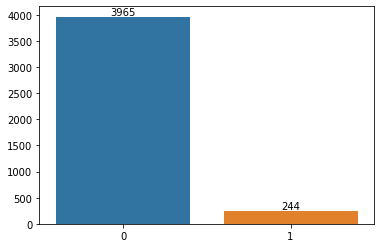

In [57]:
# Before SMOTE
chart = sns.barplot(x=y.value_counts().index, y=y.value_counts().values)
for p in chart.patches:
  chart.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
    textcoords='offset points')


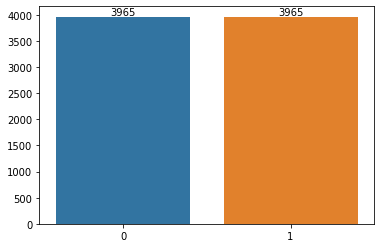

In [58]:
# After SMOTE
y_resh_s = pd.Series(y_resh)
chart = sns.barplot(x=y_resh_s.value_counts().index, y=y_resh_s.value_counts().values)
for p in chart.patches:
  chart.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
    textcoords='offset points')

### Scoring SMOTE

In [59]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=10000, random_state=seed), # We got an issue about the converge, so we limit the max_iter to 10,000 for testing
    'RandomForestClassifier': RandomForestClassifier(random_state=seed),
    'SVC': SVC(random_state=seed),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=seed),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=seed)
}

scores, y_pred = scoring_models(models, X_train_resh, X_test_resh, y_train_resh, y_test_resh)
scores

LogisticRegression
              True - Actual  False - Actual
True - Pred            1045             141
Flase - Pred             60            1133
********************
RandomForestClassifier
              True - Actual  False - Actual
True - Pred            1128              58
Flase - Pred             40            1153
********************
SVC
              True - Actual  False - Actual
True - Pred             937             249
Flase - Pred            369             824
********************
DecisionTreeClassifier
              True - Actual  False - Actual
True - Pred            1118              68
Flase - Pred            101            1092
********************
GradientBoostingClassifier
              True - Actual  False - Actual
True - Pred            1080             106
Flase - Pred             63            1130
********************


,Model,Recall,Accuracy,Precision,F1
0,LogisticRegression,0.881113,0.915511,0.945701,0.912265
1,RandomForestClassifier,0.951096,0.958806,0.965753,0.958369
2,SVC,0.790051,0.740227,0.717458,0.752006
3,DecisionTreeClassifier,0.942664,0.928962,0.917145,0.929730
4,GradientBoostingClassifier,0.910624,0.928962,0.944882,0.927437


## Cross Validation

In [60]:
scores = pd.DataFrame(columns=['Model', 'Recall', 'Accuracy', 'Precision', 'F1'])
measures = ['recall', 'accuracy', 'precision']

for name, model in models.items():
  recall = cross_val_score(model , X_resh, y_resh, cv=10, scoring='recall').mean()
  accuracy = cross_val_score(model , X_resh, y_resh, cv=10, scoring='accuracy').mean()
  precision = cross_val_score(model , X_resh, y_resh, cv=10, scoring='precision').mean()
  f1 = cross_val_score(model ,X_resh, y_resh, cv=10, scoring='f1').mean()
  scores = scores.append({'Model': name, 'Recall': recall, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1}, ignore_index=True)

scores

,Model,Recall,Accuracy,Precision,F1
0,LogisticRegression,0.867659,0.883733,0.895834,0.874796
1,RandomForestClassifier,0.950625,0.907062,0.880704,0.906900
2,SVC,0.792951,0.741362,0.720708,0.754459
3,DecisionTreeClassifier,0.941032,0.871122,0.832105,0.877453
4,GradientBoostingClassifier,0.905989,0.806053,0.784371,0.826574


In [121]:
RandomForestClassifier(random_state=seed).get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1445,
 'verbose': 0,
 'warm_start': False}

## GridSearch - RandomForest

In [122]:
n_estimators = list(range(100, 310+1, 30))
max_features = list(range(2, 6+1, 2))
bootstrap = [True, False]
min_samples_split = [2, 4, 6]
# n_estimators = list(range(100, 400+1, 100))
# max_features = list(range(2, 6+1, 2))
# bootstrap = [True]

param_grid = {'n_estimators': n_estimators,
             'max_features': max_features,
             'bootstrap': bootstrap,
             'min_samples_split': min_samples_split}

In [123]:
# param_grid = {'bootstrap': [True],
#  'ccp_alpha': [0.0],
#  'class_weight': [None],
#  'criterion': ['gini'],
#  'max_depth': [None],
#  'max_features': ['auto'],
#  'max_leaf_nodes': [None],
#  'max_samples': [None],
#  'min_impurity_decrease': [0.0],
#  'min_samples_leaf': [1],
#  'min_samples_split': [2],
#  'min_weight_fraction_leaf': [0.0],
#  'n_estimators': [100],
#  'n_jobs': [None],
#  'oob_score': [False],
#  'random_state': [1445],
#  'verbose': [0],
#  'warm_start': [False]}

In [124]:
rf = GridSearchCV(RandomForestClassifier(random_state=seed), param_grid, cv=10, scoring='recall')
scores, y_pred = scoring_models(rf, X_train_resh, X_test_resh, y_train_resh, y_test_resh)

print()
print(rf.best_params_)
print()
scores

              True - Actual  False - Actual
True - Pred            1130              56
Flase - Pred             32            1161

{'bootstrap': True, 'max_features': 6, 'min_samples_split': 2, 'n_estimators': 280}



,Model,Recall,Accuracy,Precision,F1
0,GridSearchCV,0.952782,0.96301,0.972461,0.962521


# Feature Importance

In [125]:
rf.best_estimator_.feature_importances_

pd.DataFrame({'Feature':X.columns, 'Importance':rf.best_estimator_.feature_importances_}).sort_values('Importance', ascending=False)[:10]

,Feature,Importance
1,age,0.337207
6,avg_glucose_level,0.121636
7,bmi,0.084747
10,smoking_never_smoked,0.063105
9,smoking_formerly_smoked,0.058925
15,work_Self-employed,0.058514
8,smoking_Unknown,0.055864
11,smoking_smokes,0.051404
12,work_Govt_job,0.046614
14,work_Private,0.046488


In [126]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

# To do list:
1. Cross Validation - V
2. GridSearch - V
3. Best Features Selection - V
4. Cleaning the notebook -V
5. Presentation - V

* Graphs - V
* SMOTE - V

Impressions from that new notebook:
1. He replaced NULL BMI with a decision tree!!! - X

# Grade 100!@#!